# **Specification of the dataset using a Structural Equation Model (SEM) and clarification of the intervention.**

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

class FixableDataFrame(pd.DataFrame):
    """Helper class for manipulating generative models with fixed variables."""

    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super().__init__(*args, **kwargs)

    def __setitem__(self, key, value):
        out = super().__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super().__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

def generator(n, fixed={}, seed=0):
    """Generative model with a continuous output variable for customer satisfaction."""
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # Define the continuous features with reduced randomness
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,))
    X["Interactions"] = X["Sales calls"] + np.random.normal(0.5, 0.05, size=(n,))
    X["Economy"] = np.random.uniform(0.5, 1, size=(n,))  # Reduced variability
    X["Last upgrade"] = np.random.uniform(0, 10, size=(n,))  # Reduced range
    X["Product need"] = X["Sales calls"] * 0.1 + np.random.normal(0, 0.1, size=(n,))  # Reduced noise
    X["Discount"] = ((1 - scipy.special.expit(X["Product need"])) * 0.5
                     + 0.5 * np.random.uniform(0, 0.1, size=(n,))) / 2  # Less randomness
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3
                                             + np.random.normal(0, 0.1, size=(n,)))  # Reduced noise
    X["Ad spend"] = X["Monthly usage"] * np.random.uniform(0.95, 0.99, size=(n,)) + (10 - X["Last upgrade"]) * 0.05
    X["Bugs faced"] = np.random.uniform(0, 2, size=(n,))  # Reduced number of bugs
    X["Bugs reported"] = X["Bugs faced"] * scipy.special.expit(X["Product need"])

    # Continuous output: Customer Satisfaction with stronger deterministic relationships
    X["Customer Satisfaction"] = (
        10 * (
            0.5 * X["Product need"]  # Stronger weight for Product need
            + 0.3 * X["Monthly usage"]  # Stronger weight for Monthly usage
            + 0.2 * X["Economy"]
            + 0.1 * X["Discount"]
            + 0.1 * (1 - X["Bugs faced"] / 5)
            + 0.02 * X["Sales calls"]
            + 0.03 * X["Interactions"]
            + 0.2 / (X["Last upgrade"] / 4 + 0.25)
            + X["Ad spend"] * 0
            - 0.1
        )
    )

    return X

def create_continuous_dataset():
    """Generates the dataset and separates features and the output for modeling."""
    n = 10000
    X_full = generator(n)
    y = X_full["Customer Satisfaction"]
    X = X_full.drop(["Customer Satisfaction", "Product need", "Bugs faced"], axis=1)
    return X, y

# **Assessing the Impact of Each Variable on Customer Satisfaction Using SHAP Values**

 **Specification of the XGBoost model**

In [2]:
def fit_xgboost_regression(X, y):
    """Train an XGBoost regression model and calculate the R^2 score."""
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert data to DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set parameters for regression
    params = {
        "eta": 0.1,
        "subsample": 0.9,
        "max_depth": 4,
        "objective": "reg:squarederror"
    }

    # Train the model with early stopping
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtest, "eval")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict and calculate the R^2 score
    y_pred = model.predict(dtest)
    r2 = r2_score(y_test, y_pred)
    print(f"R^2 Score: {r2:.4f}")

    return model

# Generate the dataset
X, y = create_continuous_dataset()

# Train the model and evaluate it
model = fit_xgboost_regression(X, y)

R^2 Score: 0.9604


In [3]:
X.columns

Index(['Sales calls', 'Interactions', 'Economy', 'Last upgrade', 'Discount',
       'Monthly usage', 'Ad spend', 'Bugs reported'],
      dtype='object')

In [4]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[01:16:34] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


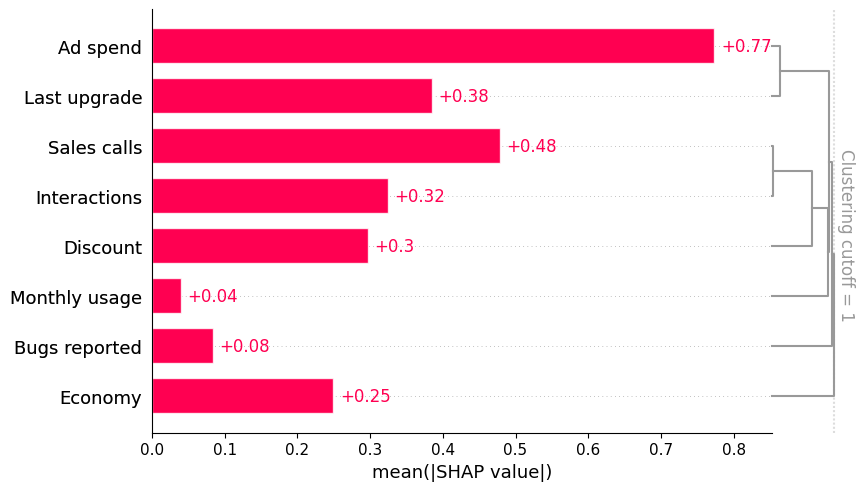

In [5]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

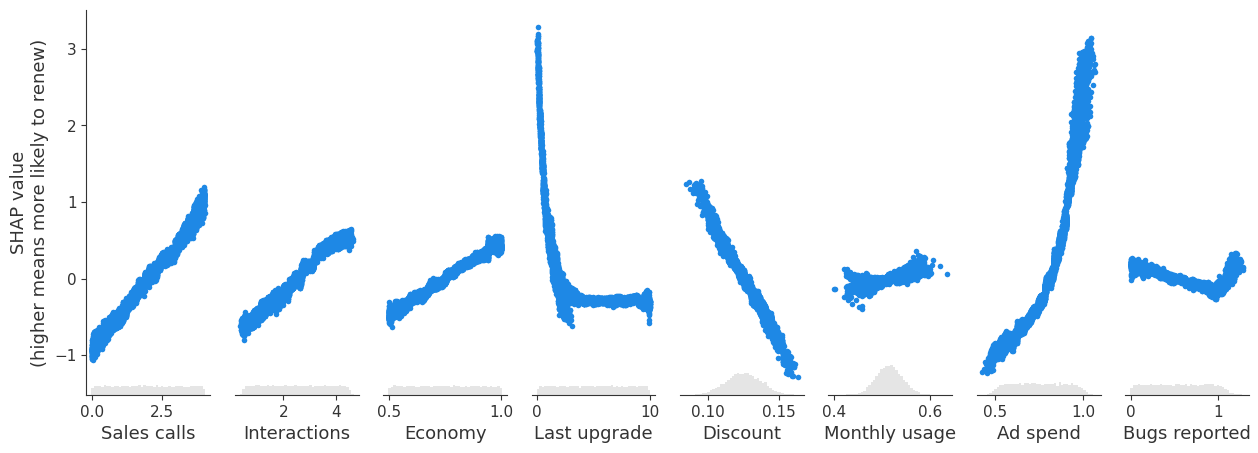

In [6]:
shap.plots.scatter(
    shap_values, ylabel="SHAP value\n(higher means more likely to renew)"
)

# **Visualization of the DAG (Directed Acyclic Graph)**

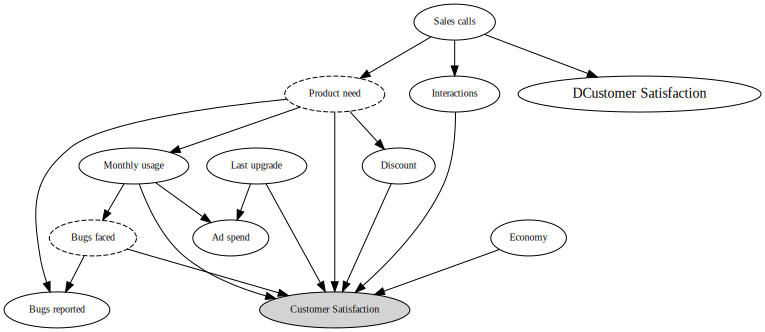

In [7]:
import graphviz

names = [
    "Bugs reported",
    "Monthly usage",
    "Sales calls",
    "Economy",
    "Discount",
    "Last upgrade",
    "Ad spend",
    "Interactions",
]
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Customer Satisfaction", style="filled", fontsize="10")

g.edge("Product need", "Customer Satisfaction")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Customer Satisfaction")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Customer Satisfaction")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Customer Satisfaction")
g.edge("Sales calls", "DCustomer Satisfaction")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Customer Satisfaction")
g.edge("Bugs faced", "Customer Satisfaction")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Customer Satisfaction")
g.edge("Last upgrade", "Ad spend")
g

# **PEACE of Degree $d$ of Each Variable on Customer Satisfaction**

**For each input variable $V$, determining the expected value of customer satisfaction under various interventions on $V$**

In [8]:
def marginal_effects(
    generative_model, num_samples=10000, columns=None, max_points=50, logit=False, seed=0
):
    """Helper function to compute the true marginal causal effects."""
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i, c in enumerate(columns):
        xs[i] = np.unique(
            [
                np.nanpercentile(xs[i], v, method="nearest")
                for v in np.linspace(0, 100, max_points)
            ]
        )
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Customer Satisfaction"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    return list(zip(xs, ys))

In [9]:
result = marginal_effects(generator, 10000, columns = X.columns)
result

[(array([2.89798554e-04, 6.97550378e-02, 1.52488997e-01, 2.33250394e-01,
         3.12210081e-01, 3.99632295e-01, 4.72944515e-01, 5.58020775e-01,
         6.29583396e-01, 7.07720215e-01, 7.95212628e-01, 8.81256279e-01,
         9.58707552e-01, 1.04685041e+00, 1.12235991e+00, 1.20204727e+00,
         1.28299166e+00, 1.37226773e+00, 1.46207244e+00, 1.54218271e+00,
         1.61909452e+00, 1.69435055e+00, 1.78165326e+00, 1.85796141e+00,
         1.93558559e+00, 2.01206154e+00, 2.09684679e+00, 2.17698299e+00,
         2.26640582e+00, 2.34020404e+00, 2.42982982e+00, 2.50569699e+00,
         2.59365481e+00, 2.68079055e+00, 2.76684274e+00, 2.85198679e+00,
         2.93388169e+00, 3.01616176e+00, 3.09413247e+00, 3.17309426e+00,
         3.25300305e+00, 3.34407033e+00, 3.42849967e+00, 3.51461227e+00,
         3.59234117e+00, 3.67268693e+00, 3.75286508e+00, 3.83437779e+00,
         3.91173276e+00, 3.99991181e+00]),
  array([5.00416188, 5.07475279, 5.15882746, 5.24089762, 5.3211369 ,
         5.4

 **Estimating the Density Function of Each Input Variable Using the KDE Method**

In [10]:
from sklearn.neighbors import KernelDensity

# Function to fit KDE and return a probability density function
def fit_kde_and_get_pdf(column_data):
    # Reshape data for sklearn (it expects a 2D array)
    data = column_data.values.reshape(-1, 1)

    # Fit the KDE model
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data)

    # Define a function to represent the PDF using the KDE
    def pdf(x):
        return np.exp(kde.score_samples([[x]]))[0]

    return pdf

# Dictionary to hold the PDF functions for each column
pdf_functions = {}

data = create_continuous_dataset()[0]
for column in data:
    pdf_functions[column] = fit_kde_and_get_pdf(data[column])

# Now, pdf_functions contains a function for each column that computes the probability density.

 **Calculating the Mean PEACE Values of Each Input Variable's Impact on Customer Satisfaction**

In [11]:
def PEACE(d):
  peace = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    effect = 0
    for i in range(1, len(result[index][0])):
      effect += abs(result[index][1][i] - result[index][1][i-1])*((pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1]))**d)
    peace[c] = effect
  return peace

step = 0.01
length = int(1/step) + 1
d_values = np.linspace(0, 1, length)
peace_values = {c: [PEACE(d)[c] for d in d_values] for c in data.columns}

In [12]:
def Availability(d):
  availability = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    availability[c] = 0
    for i in range(1, len(result[index][0])):
      availability[c] += (result[index][0][i] - result[index][0][i-1])*((pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1]))**d)
  return availability

availability_values = {c: [Availability(d)[c] for d in d_values] for c in data.columns}
mean_peace_values = {c: np.array(peace_values[c]) / np.array(availability_values[c]) for c in data.columns}

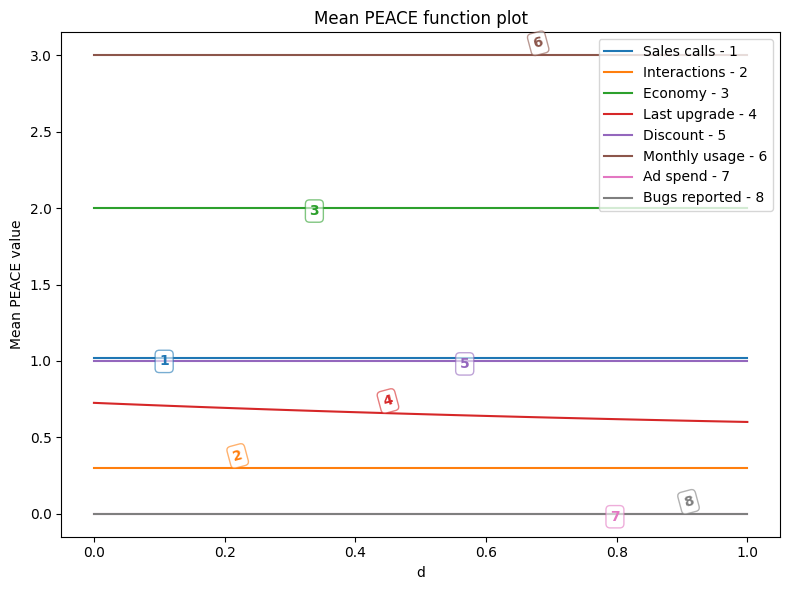

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))

def plot_mean_peace(ax, values_dict, start, end, step, ylabel, title):
    end_new = end
    length_temp = int((end_new - start) / step) + 1
    colors = plt.cm.tab10.colors  # Use a colormap for consistent coloring

    # Adjust label positions dynamically based on the number of lines
    label_positions = np.linspace(0.1, 0.9, len(values_dict))  # Dynamic label positions for flexibility

    for i, c in enumerate(values_dict):
        x_values = np.linspace(start, end_new, length_temp)
        y_values = values_dict[c][int(start / step):]
        color = colors[i % len(colors)]  # Cycle through colors if there are more than 10 entries
        ax.plot(x_values, y_values, label=f"{c} - {i+1}", color=color)

        # Position labels slightly above or below each line
        label_x_index = int(label_positions[i] * len(x_values))
        label_y_offset = (i % 2) * 10 - 5  # Alternates label position above/below
        ax.annotate(f"{i+1}",
                    xy=(x_values[label_x_index], y_values[label_x_index]),  # Position on the line at different points
                    xytext=(0, label_y_offset),  # Offset to reduce overlap
                    textcoords="offset points",
                    color=color,
                    fontsize=10,
                    fontweight='bold',
                    rotation=15 * (i % 2),  # Rotate labels slightly for better readability
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.6))  # Add a background box for readability

    ax.set_xlabel('d')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()  # Display the legend with numbers

start, end = (0, 1)
plot_mean_peace(ax, mean_peace_values, start, end, step, 'Mean PEACE value', 'Mean PEACE function plot')

plt.tight_layout()
plt.show()

 **Calculating the Mean Negative PEACE Values of Each Input Variable's Impact on Customer Satisfaction**

In [14]:
def negative(r):
  return max(-r,0)

def Negative_PEACE(d):
  peace_negative = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    effect = 0
    for i in range(1, len(result[index][0])):
      effect += negative(result[index][1][i] - result[index][1][i-1])*((pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1]))**d)
      peace_negative[c] = effect
  return peace_negative

negative_peace_values = {c: [Negative_PEACE(d)[c] for d in d_values] for c in X.columns}
mean_negative_peace_values = {c: np.array(negative_peace_values[c]) / np.array(availability_values[c]) for c in X.columns}

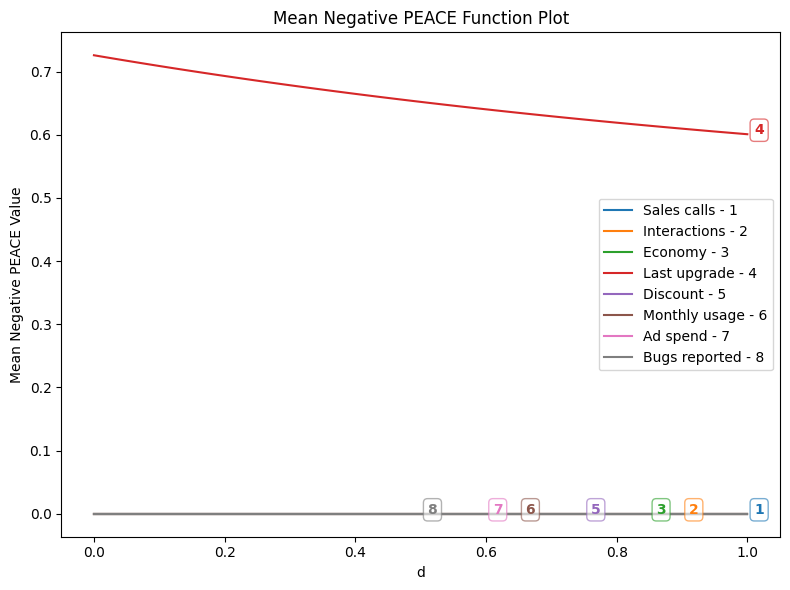

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))  # Single plot for mean PEACE-negative values

def plot_negative_mean_peace(ax, values_dict, start, end, step, ylabel, title):
    end_new = end
    length_temp = int((end_new - start) / step) + 1
    colors = plt.cm.tab10.colors  # Use a colormap for consistent coloring

    # Track used positions to manage overlap
    used_positions = []

    for i, c in enumerate(values_dict):
        x_values = np.linspace(start, end_new, length_temp)
        y_values = values_dict[c][int(start / step):]
        color = colors[i % len(colors)]  # Cycle through colors if there are more than 10 entries
        ax.plot(x_values, y_values, label=f"{c} - {i+1}", color=color)

        # Start from the end of the line and move leftward to find a position
        for j in range(len(x_values) - 1, 0, -5):
            label_x, label_y = x_values[j], y_values[j]

            # Check if this position is sufficiently far from previous labels
            if not any(abs(label_x - ux) < 0.05 and abs(label_y - uy) < 0.05 for ux, uy in used_positions):
                used_positions.append((label_x, label_y))  # Mark this position as used
                break  # Use this position and exit loop

        # Annotate label on the selected position
        ax.annotate(f"{i+1}",
                    xy=(label_x, label_y),  # Position on the line at different points
                    xytext=(5, 0),  # Slightly offset horizontally to improve readability
                    textcoords="offset points",
                    color=color,
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.6))  # Add a background box for readability

    ax.set_xlabel('d')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()  # Display the legend with numbers

# Plot the mean PEACE-negative values only
start, end = (0, 1)
plot_negative_mean_peace(ax, mean_negative_peace_values, start, end, step, 'Mean Negative PEACE Value', 'Mean Negative PEACE Function Plot')

plt.tight_layout()
plt.show()

 **Calculating the Mean Positive PEACE Values of Each Input Variable's Impact on Customer Satisfaction**

In [16]:
def positive(r):
  return max(r,0)

def Positive_PEACE(d):
  peace_positive = {}
  for c in data.columns:
    index = data.columns.get_loc(c)
    effect = 0
    for i in range(1, len(result[index][0])):
      effect += positive(result[index][1][i] - result[index][1][i-1])*((pdf_functions[c](result[index][0][i])*pdf_functions[c](result[index][0][i-1]))**d)
      peace_positive[c] = effect
  return peace_positive

positive_peace_values = {c: [Positive_PEACE(d)[c] for d in d_values] for c in X.columns}
mean_positive_peace_values = {c: np.array(positive_peace_values[c]) / np.array(availability_values[c]) for c in X.columns}

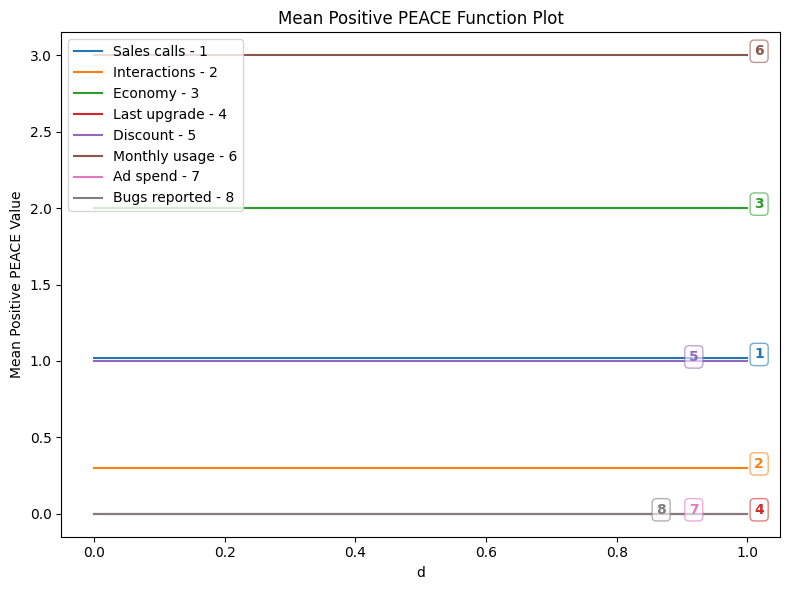

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))  # Single plot for mean PEACE-positive values

def plot_mean_positive_peace(ax, values_dict, start, end, step, ylabel, title):
    end_new = end
    length_temp = int((end_new - start) / step) + 1
    colors = plt.cm.tab10.colors  # Use a colormap for consistent coloring

    # Track used positions to manage overlap
    used_positions = []

    for i, c in enumerate(values_dict):
        x_values = np.linspace(start, end_new, length_temp)
        y_values = values_dict[c][int(start / step):]
        color = colors[i % len(colors)]  # Cycle through colors if there are more than 10 entries
        ax.plot(x_values, y_values, label=f"{c} - {i+1}", color=color)

        # Start from the end of the line and move leftward to find a position
        for j in range(len(x_values) - 1, 0, -5):
            label_x, label_y = x_values[j], y_values[j]

            # Check if this position is sufficiently far from previous labels
            if not any(abs(label_x - ux) < 0.05 and abs(label_y - uy) < 0.05 for ux, uy in used_positions):
                used_positions.append((label_x, label_y))  # Mark this position as used
                break  # Use this position and exit loop

        # Annotate label on the selected position
        ax.annotate(f"{i+1}",
                    xy=(label_x, label_y),  # Position on the line at different points
                    xytext=(5, 0),  # Slightly offset horizontally to improve readability
                    textcoords="offset points",
                    color=color,
                    fontsize=10,
                    fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.6))  # Add a background box for readability

    ax.set_xlabel('d')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()  # Display the legend with numbers

# Plot the mean PEACE-positive values only
start, end = (0, 1)
plot_mean_positive_peace(ax, mean_positive_peace_values, start, end, step, 'Mean Positive PEACE Value', 'Mean Positive PEACE Function Plot')

plt.tight_layout()
plt.show()

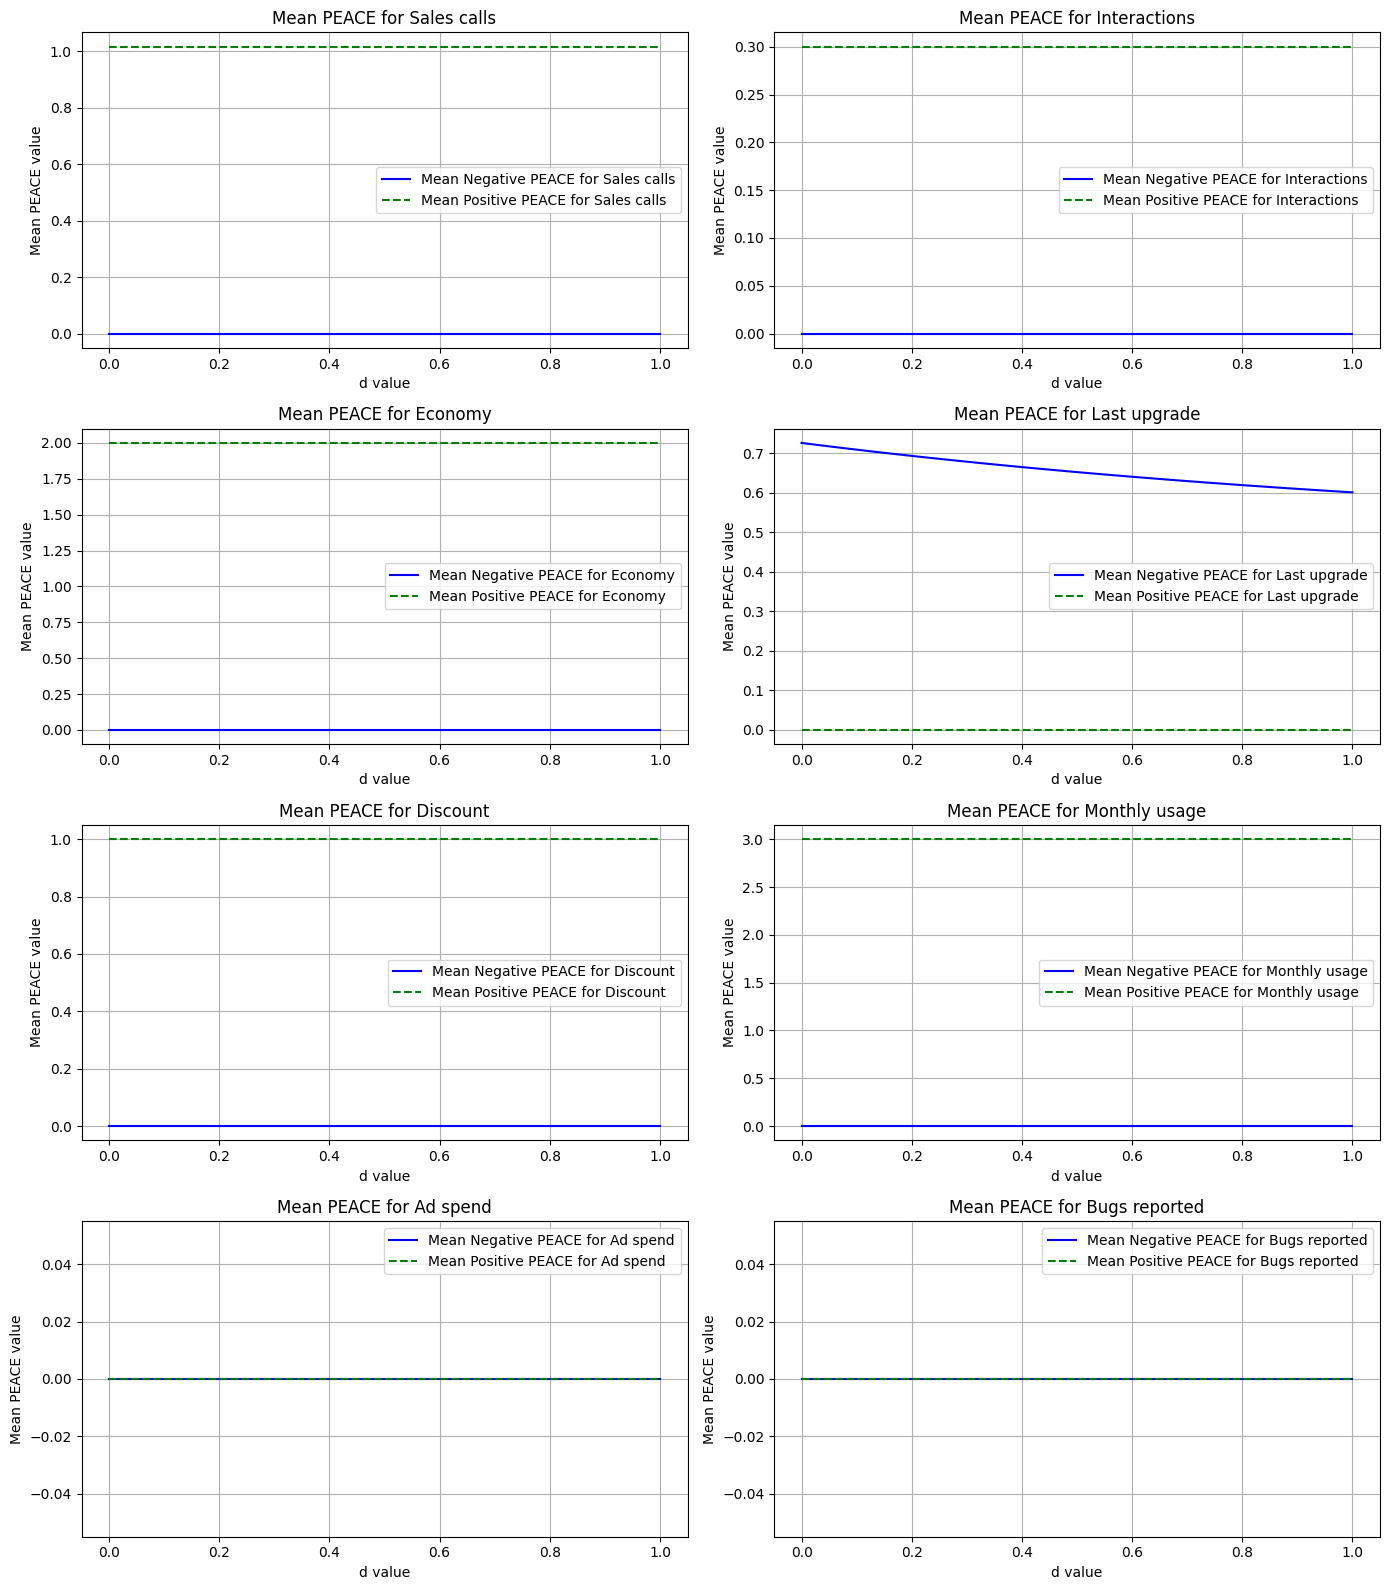

In [18]:
num_variables = len(X.columns)
n_rows = (num_variables + 1) // 2  # Number of rows needed for two plots per row

fig, axs = plt.subplots(n_rows, 2, figsize=(14, 4 * n_rows))  # Two columns for two plots per row

# Ensure axs is a 2D array even if there's only one row
axs = axs.reshape(n_rows, 2) if num_variables > 1 else [[axs[0], axs[1]]]

for i, c in enumerate(data.columns):
    row, col = divmod(i, 2)  # Determine position in the grid
    ax = axs[row][col]

    # Plot mean negative and positive PEACE values on the same plot
    if c in mean_negative_peace_values:
        ax.plot(d_values, mean_negative_peace_values[c], label=f'Mean Negative PEACE for {c}', color="blue")
    if c in mean_positive_peace_values:
        ax.plot(d_values, mean_positive_peace_values[c], label=f'Mean Positive PEACE for {c}', color="green", linestyle='--')

    # Set labels, titles, legends, and grids for each plot
    ax.set_xlabel('d value')
    ax.set_ylabel('Mean PEACE value')
    ax.set_title(f'Mean PEACE for {c}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# **Mean PEACE Impact of Two Combined Input Variables on Customer Satisfaction**

In [19]:
def marginal_effects_2d(data, max_points = 50, seed = 0):
    X = generator(10000).drop(["Customer Satisfaction", "Product need", "Bugs faced"], axis=1)
    columns = X.columns
    ys = [[[] for _ in columns] for _ in columns]
    xs = [np.sort(X[c].values) for c in columns]
    xs = [np.unique([np.nanpercentile(xs[i], v, method="nearest")
                     for v in np.linspace(0, 100, max_points)]) for i in range(len(columns))]

    for i in range(len(columns)):
        for j in range(len(columns)):
            if i >= j:
                continue  # Skip same variable pairs
            for x_i in xs[i]:
                for x_j in xs[j]:
                    Xnew = generator(10000, fixed={columns[i]: x_i, columns[j]: x_j}, seed=seed)
                    val = Xnew["Customer Satisfaction"].mean()
                    ys[i][j].append(val)
            print(f'({i}, {j}) is completed.')
    print('The potential outcomes are all computed.')

    # Compute partial derivatives
    derivative = {}
    for i in range(len(columns)):
        for j in range(len(columns)):
            if i >= j:
                continue
            ys_ij = np.array(ys[i][j]).reshape(len(xs[i]), len(xs[j]))
            # Compute partial derivatives with respect to xs[i] and xs[j]
            d_y = np.gradient(ys_ij, xs[i], xs[j], edge_order=2)
            # Store derivatives in a dictionary for clarity
            derivative[(i, j)] = np.stack((d_y[0], d_y[1]), axis=-1)
            print(f'({i}, {j}) for derivatives is completed.')

    return xs, ys, derivative

In [20]:
marginal_effects_2d = marginal_effects_2d(data)

(0, 1) is completed.
(0, 2) is completed.
(0, 3) is completed.
(0, 4) is completed.
(0, 5) is completed.
(0, 6) is completed.
(0, 7) is completed.
(1, 2) is completed.
(1, 3) is completed.
(1, 4) is completed.
(1, 5) is completed.
(1, 6) is completed.
(1, 7) is completed.
(2, 3) is completed.
(2, 4) is completed.
(2, 5) is completed.
(2, 6) is completed.
(2, 7) is completed.
(3, 4) is completed.
(3, 5) is completed.
(3, 6) is completed.
(3, 7) is completed.
(4, 5) is completed.
(4, 6) is completed.
(4, 7) is completed.
(5, 6) is completed.
(5, 7) is completed.
(6, 7) is completed.
The potential outcomes are all computed.
(0, 1) for derivatives is completed.
(0, 2) for derivatives is completed.
(0, 3) for derivatives is completed.
(0, 4) for derivatives is completed.
(0, 5) for derivatives is completed.
(0, 6) for derivatives is completed.
(0, 7) for derivatives is completed.
(1, 2) for derivatives is completed.
(1, 3) for derivatives is completed.
(1, 4) for derivatives is completed.
(

In [21]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from itertools import combinations

# Function to fit KDE and return a probability density function for two-dimensional data
def fit_kde_and_get_pdf_2d(data_frame, column_pair):
    # Extract data for the pair of columns
    data = data_frame[list(column_pair)].values

    # Fit the KDE model on the 2D data
    kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(data)

    # Define a function to represent the PDF using the KDE
    def pdf(x, y):
        return np.exp(kde.score_samples([[x, y]]))[0]

    return pdf

# Dictionary to hold the PDF functions for each pair of columns
pdf_functions_2d = {}

# Iterate over all combinations of column pairs
for column_pair in combinations(X.columns, 2):
    pdf_functions_2d[column_pair] = fit_kde_and_get_pdf_2d(X, column_pair)

# Example usage:
# pdf_functions[('A', 'B')](0.5, -0.5) will give you the PDF value at (0.5, -0.5) for the pair of columns A and B

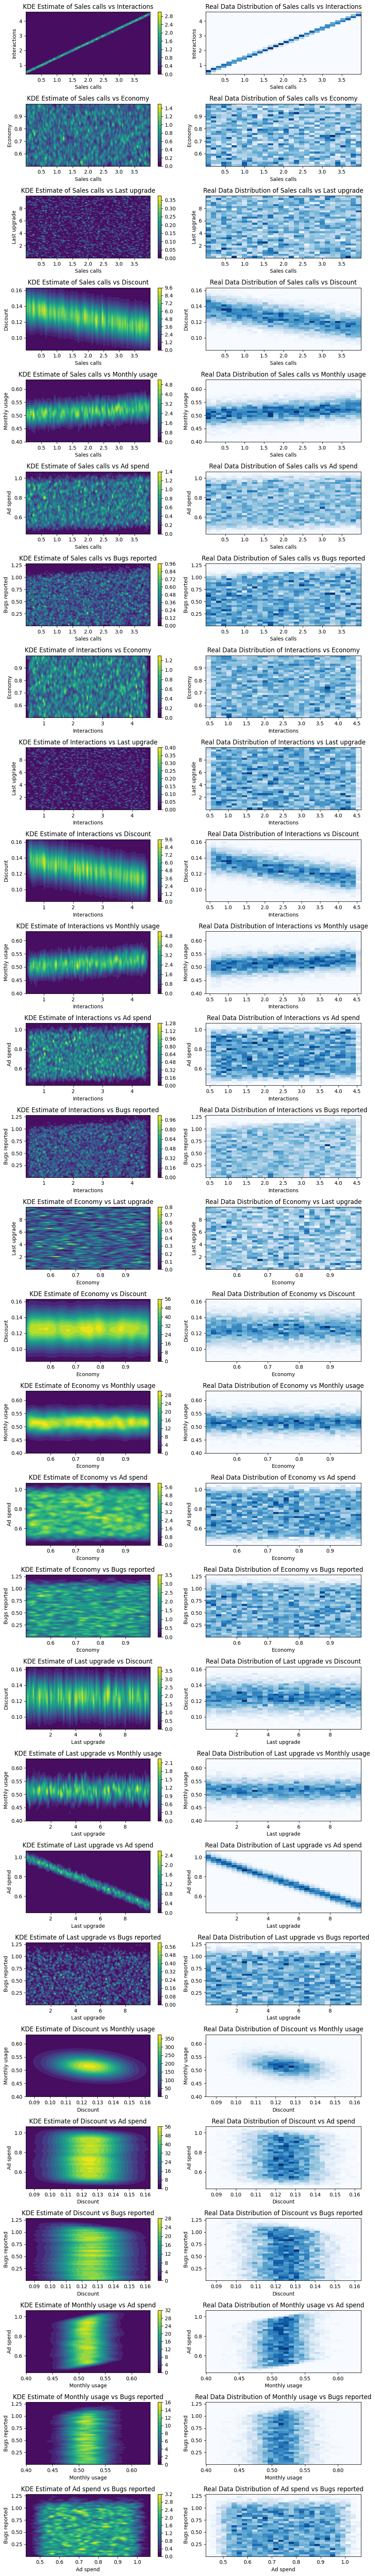

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Define parameters
grid_size = 100  # Number of points in each dimension for the grid
pdf_plots_per_row = 2  # Each pair gets two plots side-by-side (one for KDE, one for real data)

# Create a figure with side-by-side plots for each pair
num_plots = len(pdf_functions_2d)
num_rows = (num_plots * 2 + pdf_plots_per_row - 1) // pdf_plots_per_row  # Two plots per pair
fig, axs = plt.subplots(num_rows, pdf_plots_per_row, figsize=(pdf_plots_per_row * 5, num_rows * 2.5))

# Flatten axs for easy indexing if we have multiple rows
axs = axs.flatten()

# Iterate over each pair of columns and plot both KDE and actual distribution
for i, (column_pair, pdf) in enumerate(pdf_functions_2d.items()):
    # Generate the grid over which we’ll evaluate the KDE PDF
    x_min, x_max = X[column_pair[0]].min(), X[column_pair[0]].max()
    y_min, y_max = X[column_pair[1]].min(), X[column_pair[1]].max()
    x_values = np.linspace(x_min, x_max, grid_size)
    y_values = np.linspace(y_min, y_max, grid_size)
    X_grid, Y_grid = np.meshgrid(x_values, y_values)

    # Compute KDE PDF values for each point in the grid
    Z = np.array([[pdf(x, y) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X_grid, Y_grid)])

    # Plot KDE PDF as a contour plot
    ax_kde = axs[2 * i]  # Every pair has two plots
    contour = ax_kde.contourf(X_grid, Y_grid, Z, levels=15, cmap='viridis')
    fig.colorbar(contour, ax=ax_kde, orientation='vertical')
    ax_kde.set_title(f"KDE Estimate of {column_pair[0]} vs {column_pair[1]}")
    ax_kde.set_xlabel(column_pair[0])
    ax_kde.set_ylabel(column_pair[1])

    # Plot the real data distribution using a scatter plot
    ax_data = axs[2 * i + 1]
    ax_data.hist2d(X[column_pair[0]], X[column_pair[1]], bins=30, cmap='Blues')
    ax_data.set_title(f"Real Data Distribution of {column_pair[0]} vs {column_pair[1]}")
    ax_data.set_xlabel(column_pair[0])
    ax_data.set_ylabel(column_pair[1])

# Remove any unused subplots
for j in range(2 * num_plots, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [23]:
xs, ys, derivative = marginal_effects_2d

In [24]:
def PEACE_2d(d):
  peace = {}
  for c1 in X.columns:
      for c2 in X.columns:
          index1 = X.columns.get_loc(c1)
          index2 = X.columns.get_loc(c2)
          if index1 >= index2:
              continue
          effect = 0
          for i in range(len(xs[index1])-1):
              for j in range(len(xs[index2])-1):
                  effect += (xs[index1][i+1] - xs[index1][i]) * (xs[index2][j+1] - xs[index2][j])* np.sqrt(derivative[(index1,index2)][i][j][0]**2 + derivative[(index1,index2)][i][j][1]**2) * ((pdf_functions_2d[(c1, c2)](xs[index1][i], xs[index2][j]) *(pdf_functions_2d[(c1, c2)](xs[index1][i+1], xs[index2][j+1])))**d)
          peace[(c1,c2)] = effect
  return peace

In [25]:
PEACE_2d(0), PEACE_2d(0.25), PEACE_2d(0.5), PEACE_2d(0.75), PEACE_2d(1)

({('Sales calls', 'Interactions'): 13.135919951109786,
  ('Sales calls', 'Economy'): 4.48443539088936,
  ('Sales calls', 'Last upgrade'): 60.2603761317184,
  ('Sales calls', 'Discount'): 0.4494558229610943,
  ('Sales calls', 'Monthly usage'): 2.980791118498044,
  ('Sales calls', 'Ad spend'): 2.5898231951099318,
  ('Sales calls', 'Bugs reported'): 5.219235280093223,
  ('Interactions', 'Economy'): 4.274845465389984,
  ('Interactions', 'Last upgrade'): 40.038702553250474,
  ('Interactions', 'Discount'): 0.3469553594304412,
  ('Interactions', 'Monthly usage'): 3.007011688948835,
  ('Interactions', 'Ad spend'): 0.8084301591738038,
  ('Interactions', 'Bugs reported'): 1.629218247878183,
  ('Economy', 'Last upgrade'): 11.89225412409404,
  ('Economy', 'Discount'): 0.08781249672432682,
  ('Economy', 'Monthly usage'): 0.4249480322949647,
  ('Economy', 'Ad spend'): 0.6368867584868256,
  ('Economy', 'Bugs reported'): 1.283509177613008,
  ('Last upgrade', 'Discount'): 1.1730211773930483,
  ('Last u

In [26]:
# Define a range for `d` values
d_values = np.linspace(0, 1, 20)  # Example range from 0.1 to 2 with 20 points

# Initial calculation of PEACE_2d for the first d to initialize effects_over_d with keys
initial_peace_results = PEACE_2d(d_values[0])
effects_over_d = {pair: [] for pair in initial_peace_results.keys()}

# Calculate PEACE_2d(d) for each value of d and store the results
for d in d_values:
    peace_results = PEACE_2d(d)
    for pair, effect in peace_results.items():
        effects_over_d[pair].append(effect)

In [27]:
def Availability_2d(d):
  availability_2d = {}
  for c1 in X.columns:
      for c2 in X.columns:
          index1 = X.columns.get_loc(c1)
          index2 = X.columns.get_loc(c2)
          if index1 >= index2:
              continue
          effect = 0
          for i in range(len(xs[index1])-1):
              for j in range(len(xs[index2])-1):
                  effect += (xs[index1][i+1] - xs[index1][i]) * (xs[index2][j+1] - xs[index2][j]) * ((pdf_functions_2d[(c1, c2)](xs[index1][i], xs[index2][j]) *(pdf_functions_2d[(c1, c2)](xs[index1][i+1], xs[index2][j+1])))**d)
          availability_2d[(c1,c2)] = effect
  return availability_2d

In [28]:
# Initial calculation of PEACE_2d for the first d to initialize effects_over_d with keys
initial_availability_results = Availability_2d(d_values[0])
availability_effects_over_d = {pair: [] for pair in initial_availability_results.keys()}

# Calculate PEACE_2d(d) for each value of d and store the results
for d in d_values:
    availability_results = Availability_2d(d)
    for pair, effect in availability_results.items():
        availability_effects_over_d[pair].append(effect)

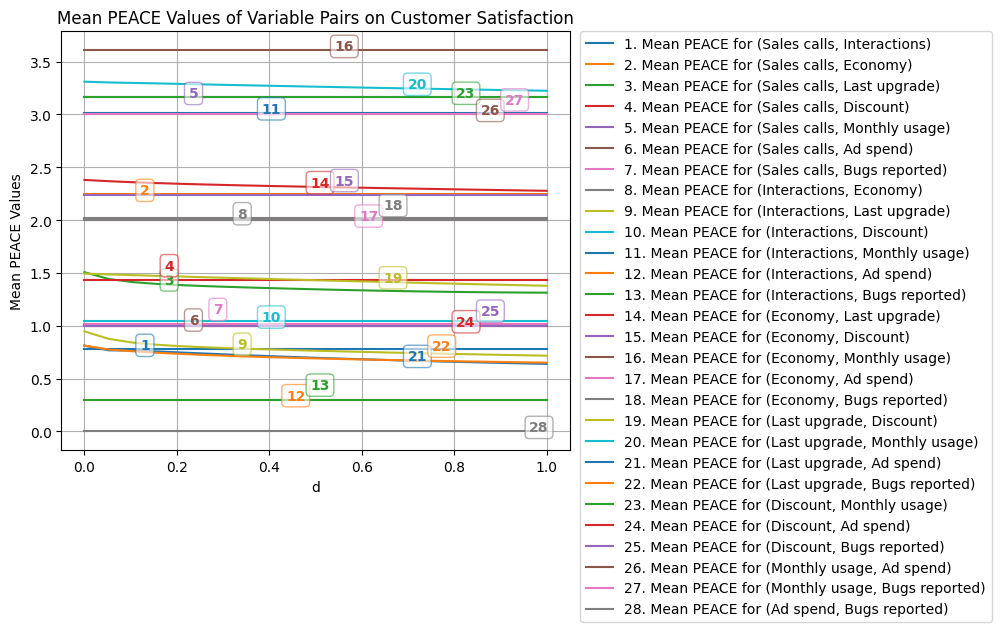

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean_peace_values_2d by element-wise division
mean_peace_values_2d = {}
for pair in effects_over_d.keys():
    effect_array = np.array(effects_over_d[pair])
    availability_array = np.array(availability_effects_over_d[pair])
    with np.errstate(divide='ignore', invalid='ignore'):
        mean_values = np.true_divide(effect_array, availability_array)
        mean_values[~np.isfinite(mean_values)] = 0  # Replace infinities and NaNs with zero
    mean_peace_values_2d[pair] = mean_values

# Plot the mean PEACE values over d for each pair
plt.figure(figsize=(12, 6))  # Adjust figure width for more space

colors = plt.cm.tab10.colors  # Colormap for consistent coloring
label_positions = np.linspace(0.1, 0.9, len(mean_peace_values_2d))  # Positions for each label
vertical_offset = 0  # Start without vertical offset

for i, (pair, mean_values) in enumerate(mean_peace_values_2d.items()):
    color = colors[i % len(colors)]  # Cycle through colors if needed
    plt.plot(d_values, mean_values, label=f"{i+1}. Mean PEACE for ({pair[0]}, {pair[1]})", color=color)

    # Determine an appropriate x-position along the line
    label_x_index = int(label_positions[i] * len(d_values))
    label_x, label_y = d_values[label_x_index], mean_values[label_x_index]

    # Adjust vertical position to reduce overlap
    if i > 0 and abs(label_y - previous_y) < 0.1:
        vertical_offset += 0.1  # Increment the vertical offset if close to previous label
    else:
        vertical_offset = 0  # Reset offset if there’s enough space

    # Annotate numeric label on the selected position on the line with vertical offset
    plt.annotate(f"{i+1}",
                 xy=(label_x, label_y + vertical_offset),
                 xytext=(5, 0),
                 textcoords="offset points",
                 color=color,
                 fontsize=10,
                 fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white", alpha=0.6))  # Background box for readability

    previous_y = label_y  # Update previous_y for the next loop

plt.xlabel('d')
plt.ylabel('Mean PEACE Values')
plt.title('Mean PEACE Values of Variable Pairs on Customer Satisfaction')

# Place the legend outside the plot area on the right
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()

# **Shap Interaction Values**

[02:21:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


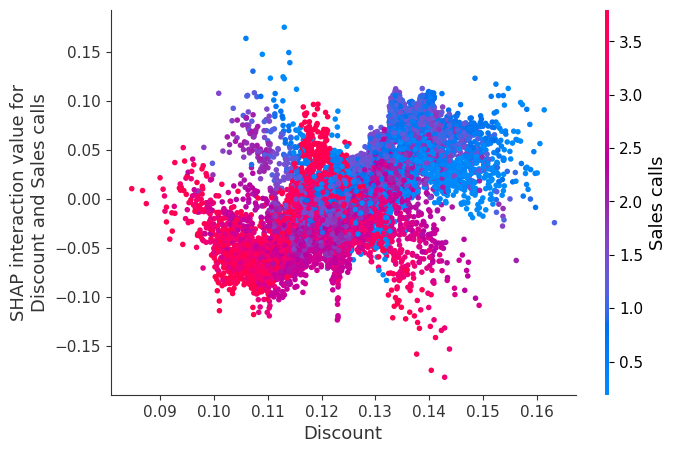

Mean joint effect of Discount and Sales calls: 0.0006928190123289824


In [30]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values and interaction values
shap_values = explainer.shap_values(X)
shap_interaction_values = explainer.shap_interaction_values(X)

# Define the two features you want to analyze
feature1 = 'Discount'
feature2 = 'Sales calls'

# Find their index in the dataset
index1 = X.columns.get_loc(feature1)
index2 = X.columns.get_loc(feature2)

# Extract interaction values between the two specified features
interaction_values = shap_interaction_values[:, index1, index2]

# Plot SHAP dependence plot to visualize the interaction
shap.dependence_plot((feature1, feature2), shap_interaction_values, X)

# Calculate and display the mean joint effect of the two features
mean_interaction_effect = np.mean(interaction_values)
print(f"Mean joint effect of {feature1} and {feature2}: {mean_interaction_effect}")


[02:21:55] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


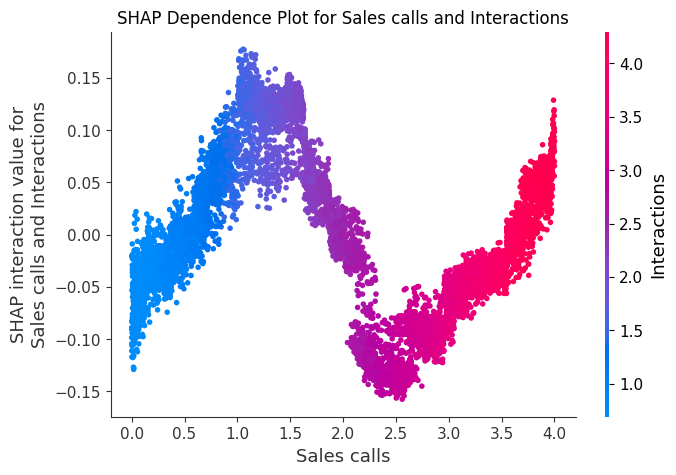

Mean joint effect of Sales calls and Interactions: -0.0015429925406351686


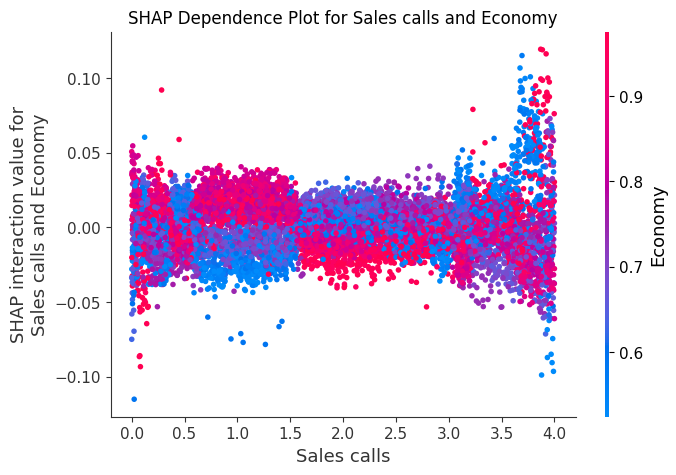

Mean joint effect of Sales calls and Economy: -4.3483771150931716e-05


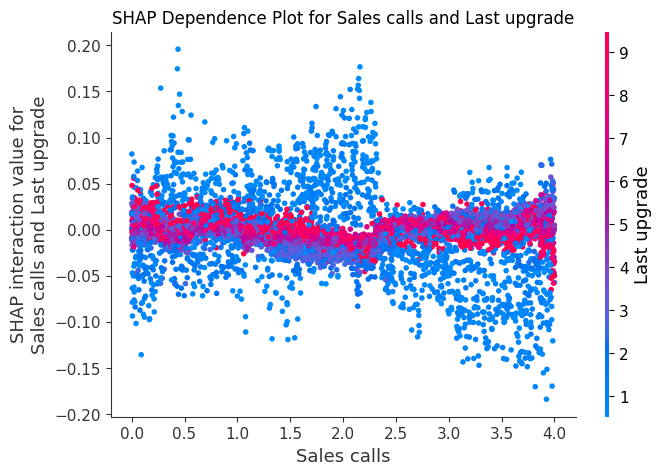

Mean joint effect of Sales calls and Last upgrade: -0.001111555495299399


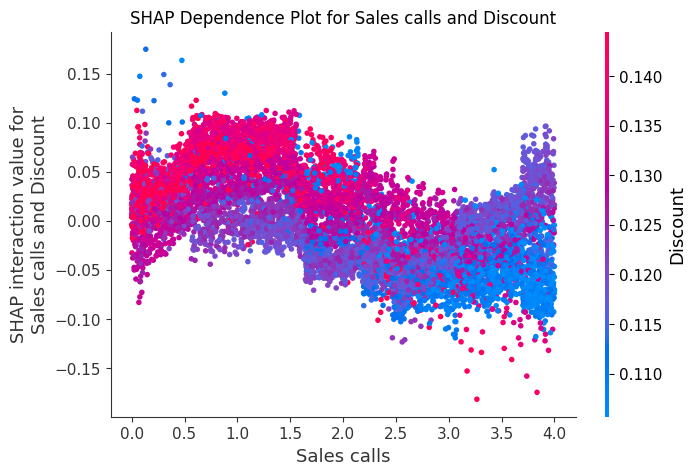

Mean joint effect of Sales calls and Discount: 0.0006928305374458432


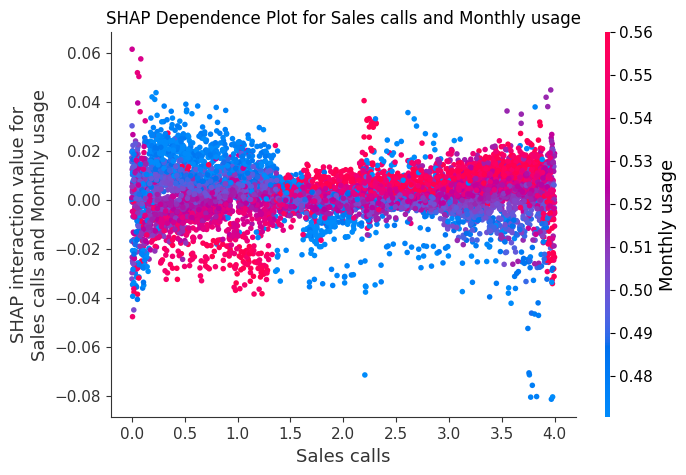

Mean joint effect of Sales calls and Monthly usage: 0.0009479555883444846


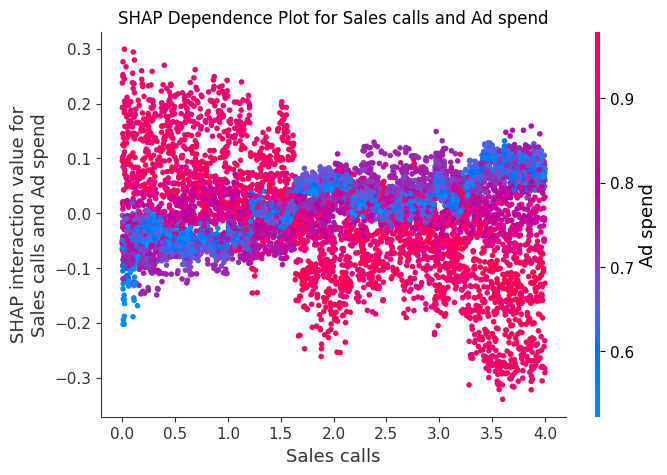

Mean joint effect of Sales calls and Ad spend: -0.00028869410743936896


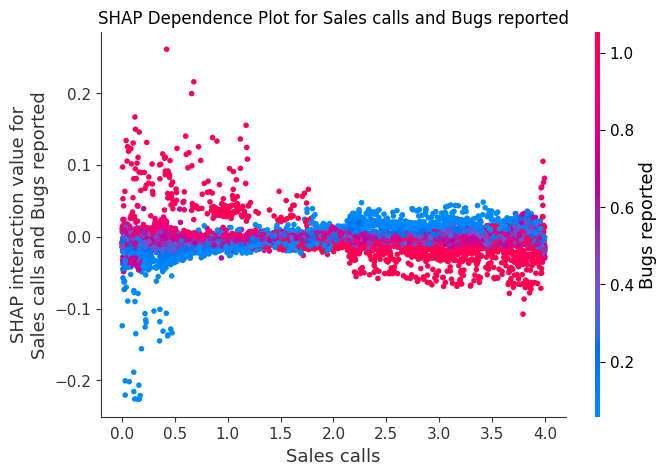

Mean joint effect of Sales calls and Bugs reported: -0.001362133421935141


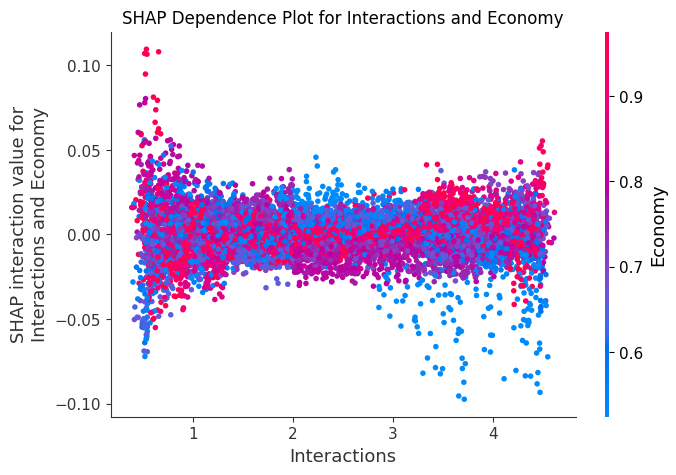

Mean joint effect of Interactions and Economy: -7.940673094708472e-05


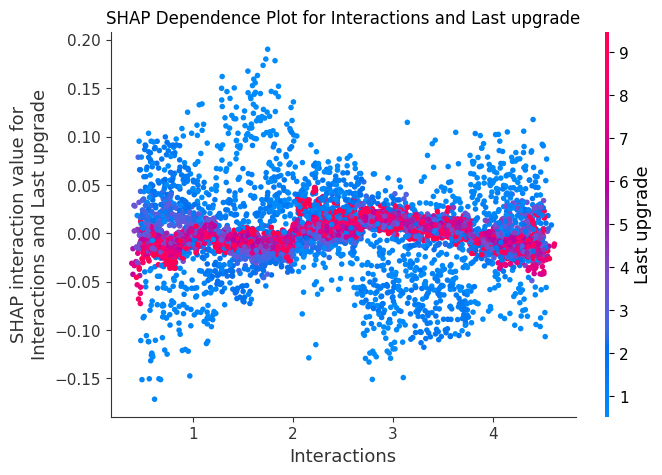

Mean joint effect of Interactions and Last upgrade: 4.6108536480460316e-05


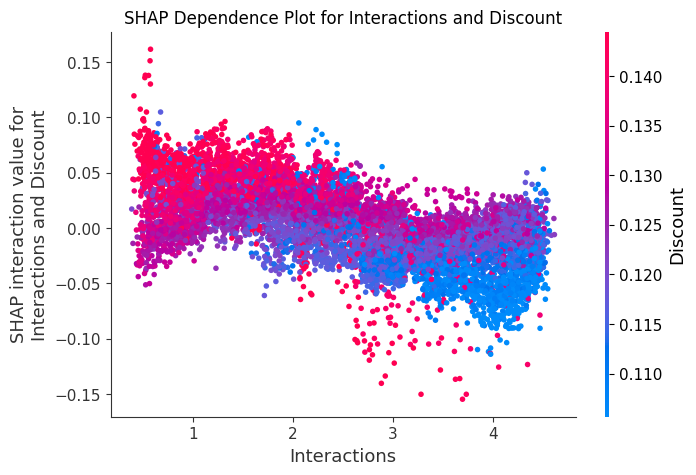

Mean joint effect of Interactions and Discount: 0.0018208251567557454


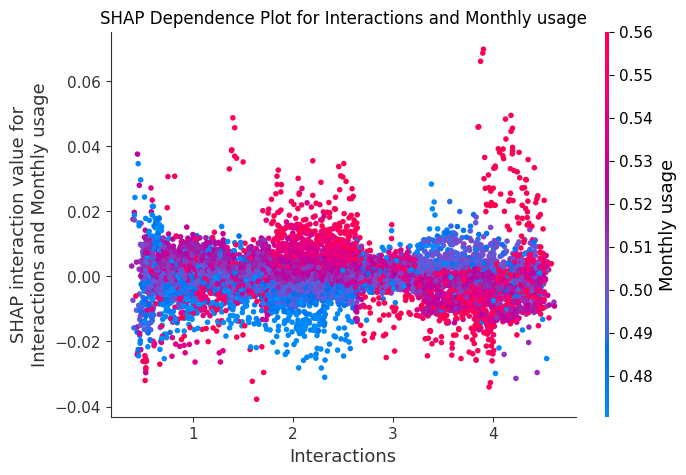

Mean joint effect of Interactions and Monthly usage: -0.00011241798347327858


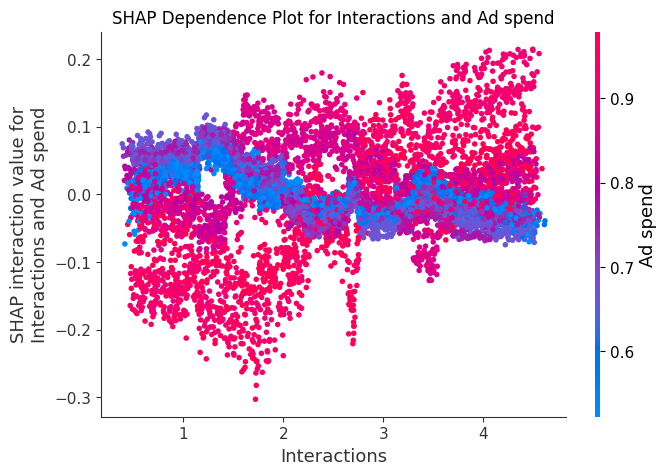

Mean joint effect of Interactions and Ad spend: 0.0005753044388256967


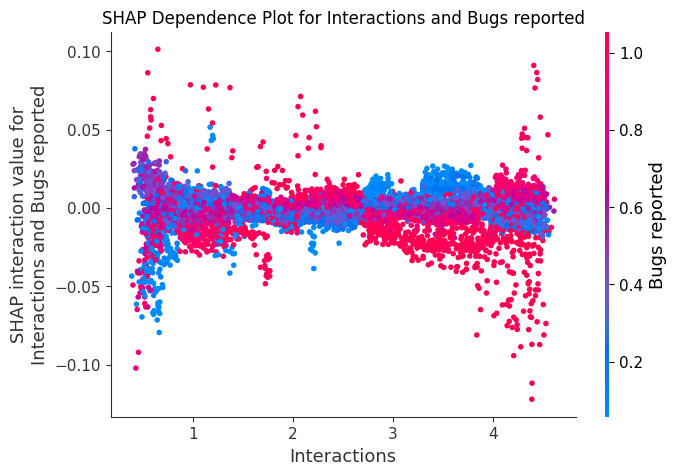

Mean joint effect of Interactions and Bugs reported: -0.0007175306091085076


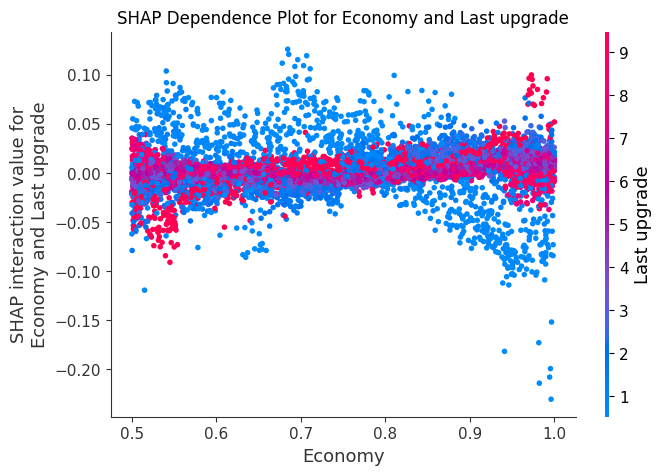

Mean joint effect of Economy and Last upgrade: 0.0006057416903786361


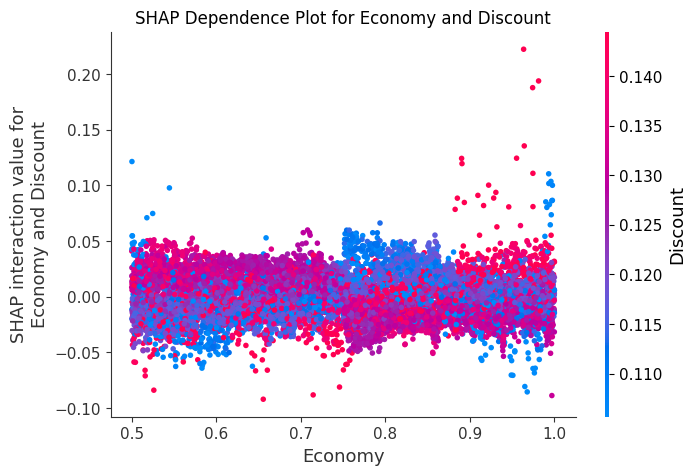

Mean joint effect of Economy and Discount: 2.0502535335253924e-05


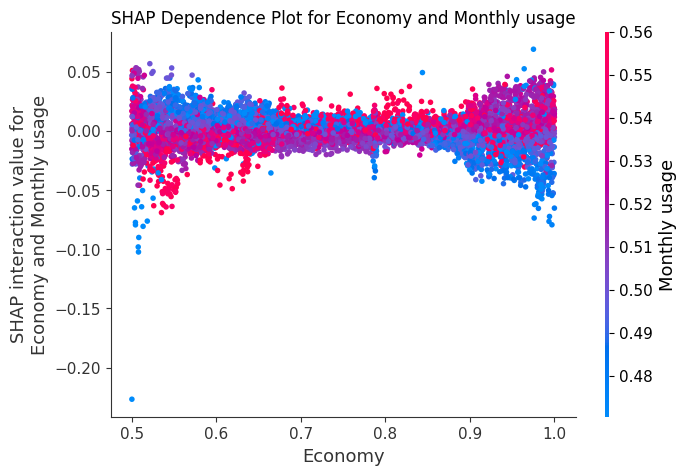

Mean joint effect of Economy and Monthly usage: 5.7532965001882985e-05


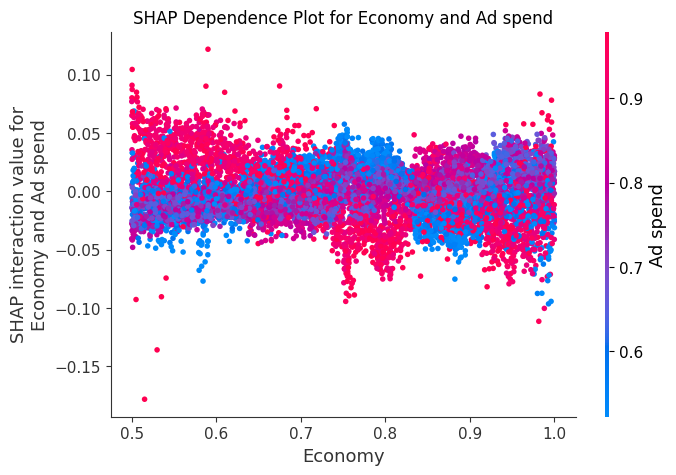

Mean joint effect of Economy and Ad spend: -0.000801642017904669


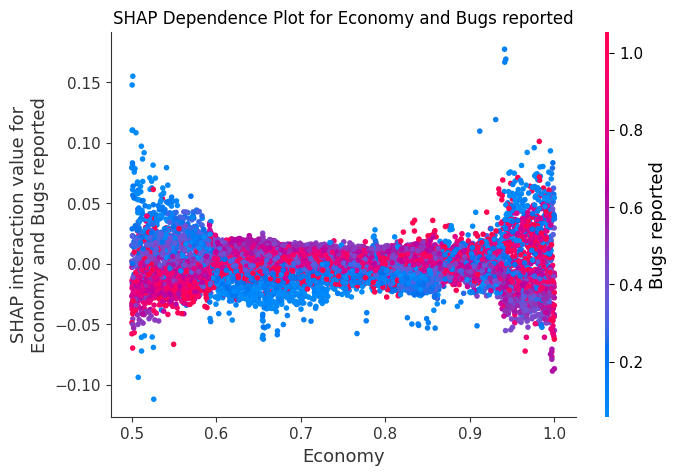

Mean joint effect of Economy and Bugs reported: -6.377985118888319e-05


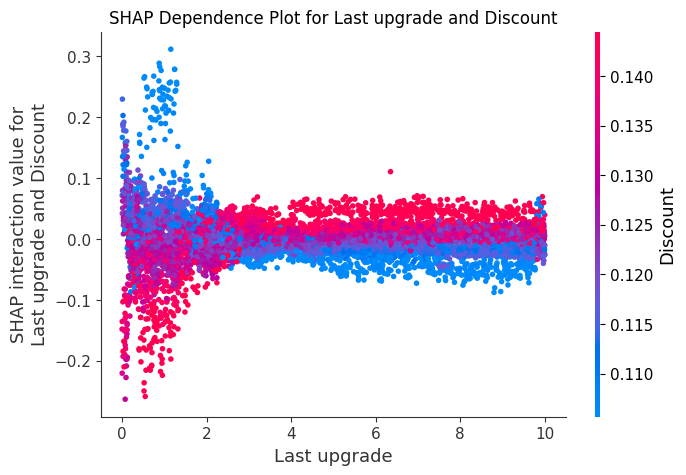

Mean joint effect of Last upgrade and Discount: -0.00012135441647842526


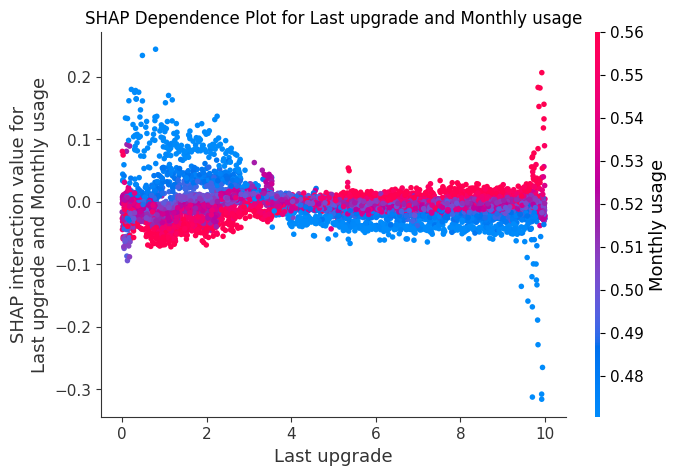

Mean joint effect of Last upgrade and Monthly usage: -0.002375916810706258


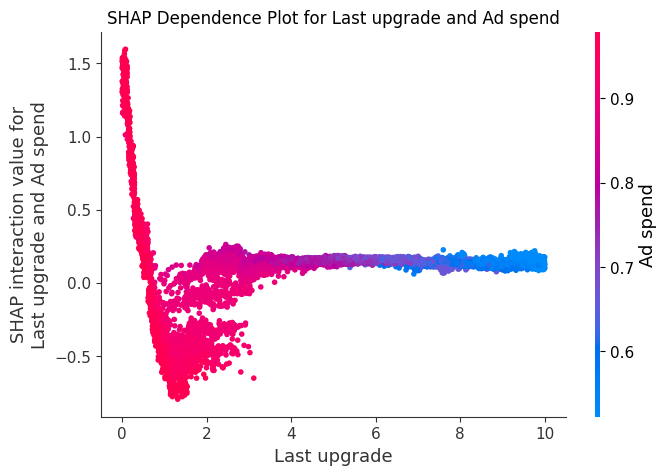

Mean joint effect of Last upgrade and Ad spend: 0.04752478003501892


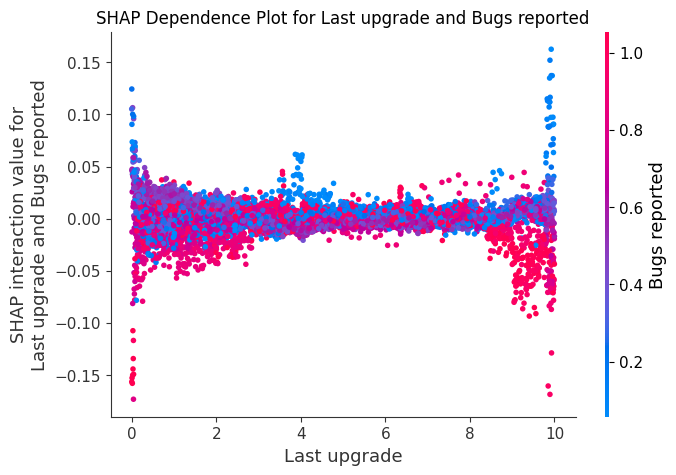

Mean joint effect of Last upgrade and Bugs reported: -3.8768790545873344e-05


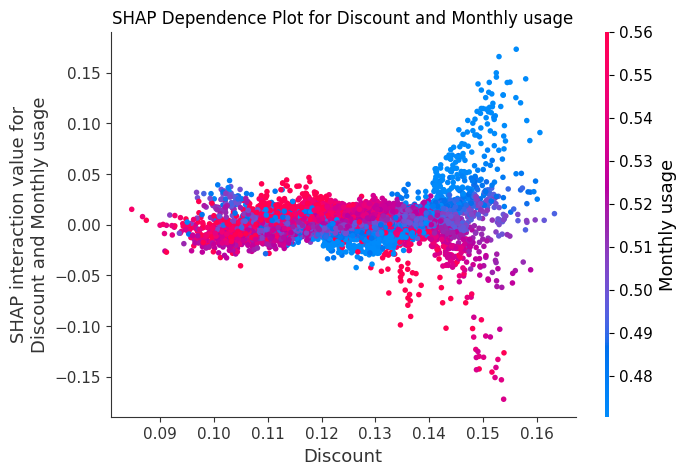

Mean joint effect of Discount and Monthly usage: 0.0010039119515568018


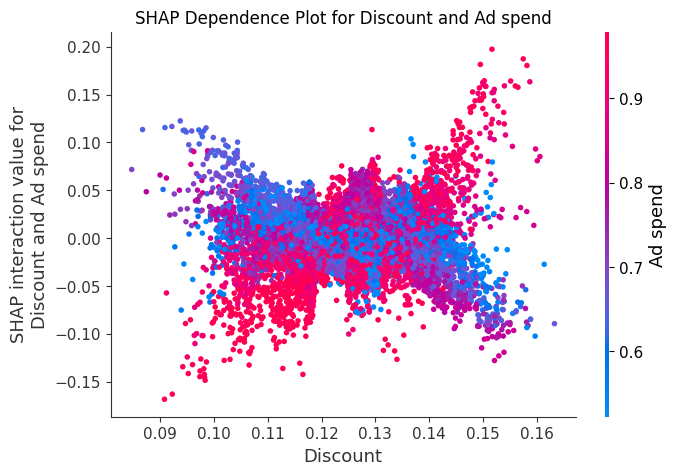

Mean joint effect of Discount and Ad spend: -2.357074845349416e-05


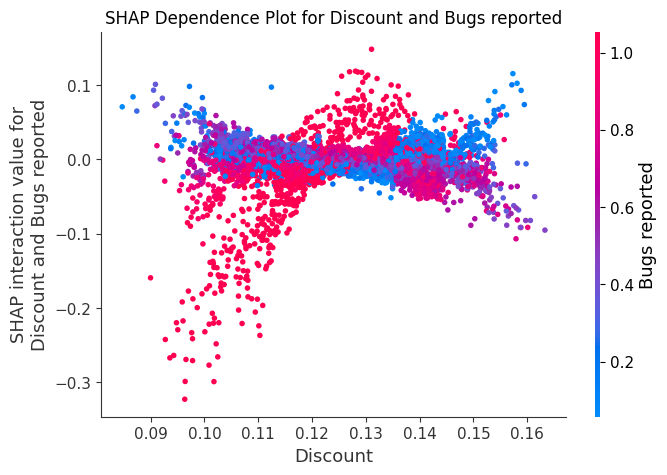

Mean joint effect of Discount and Bugs reported: -0.001807791762985289


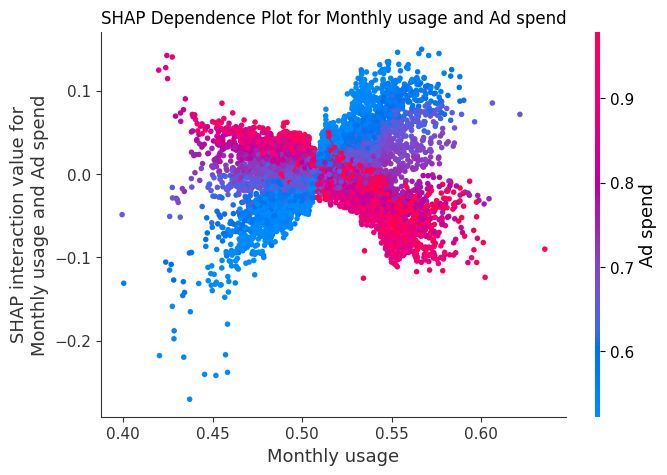

Mean joint effect of Monthly usage and Ad spend: 0.0008424327825196087


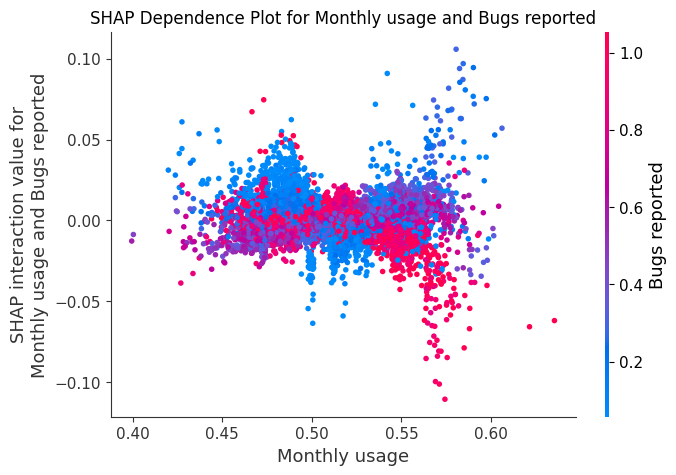

Mean joint effect of Monthly usage and Bugs reported: -7.114939944585785e-05


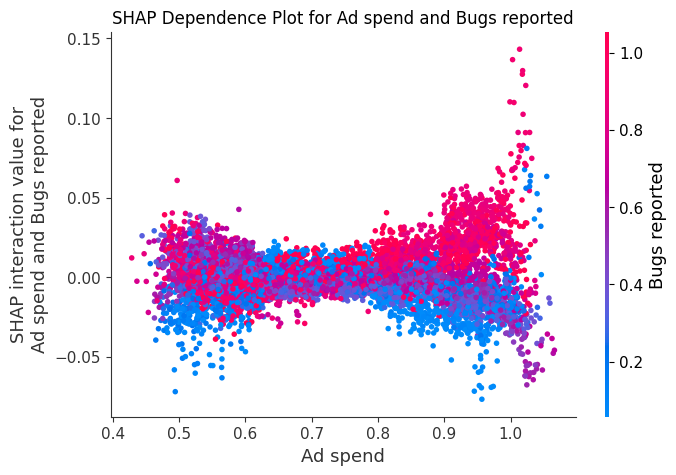

Mean joint effect of Ad spend and Bugs reported: -0.00010873832798097283


In [31]:
from itertools import combinations

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values and interaction values
shap_values = explainer.shap_values(X)
shap_interaction_values = explainer.shap_interaction_values(X)

# Loop through all unique pairs of features in X
feature_names = X.columns
for feature1, feature2 in combinations(feature_names, 2):
    # Get indices of the features
    index1 = X.columns.get_loc(feature1)
    index2 = X.columns.get_loc(feature2)

    # Extract interaction values between the two specified features
    interaction_values = shap_interaction_values[:, index1, index2]

    # Plot SHAP dependence plot to visualize the interaction
    shap.dependence_plot((feature1, feature2), shap_interaction_values, X, show=False)
    plt.title(f'SHAP Dependence Plot for {feature1} and {feature2}')
    plt.show()

    # Calculate and display the mean joint effect of the two features
    mean_interaction_effect = np.mean(interaction_values)
    print(f"Mean joint effect of {feature1} and {feature2}: {mean_interaction_effect}")

# **Causal Forest Method**

In [32]:
pip install econml

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


2024-11-18 02:22:06,297	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Summary of Average Treatment Effects:
Average Estimated Treatment Effects:

Sales calls: 1.0149
Discount: -80.7860
Ad spend: 8.7514
Monthly usage: 21.2242
Last upgrade: -0.4158
Interactions: 1.0130


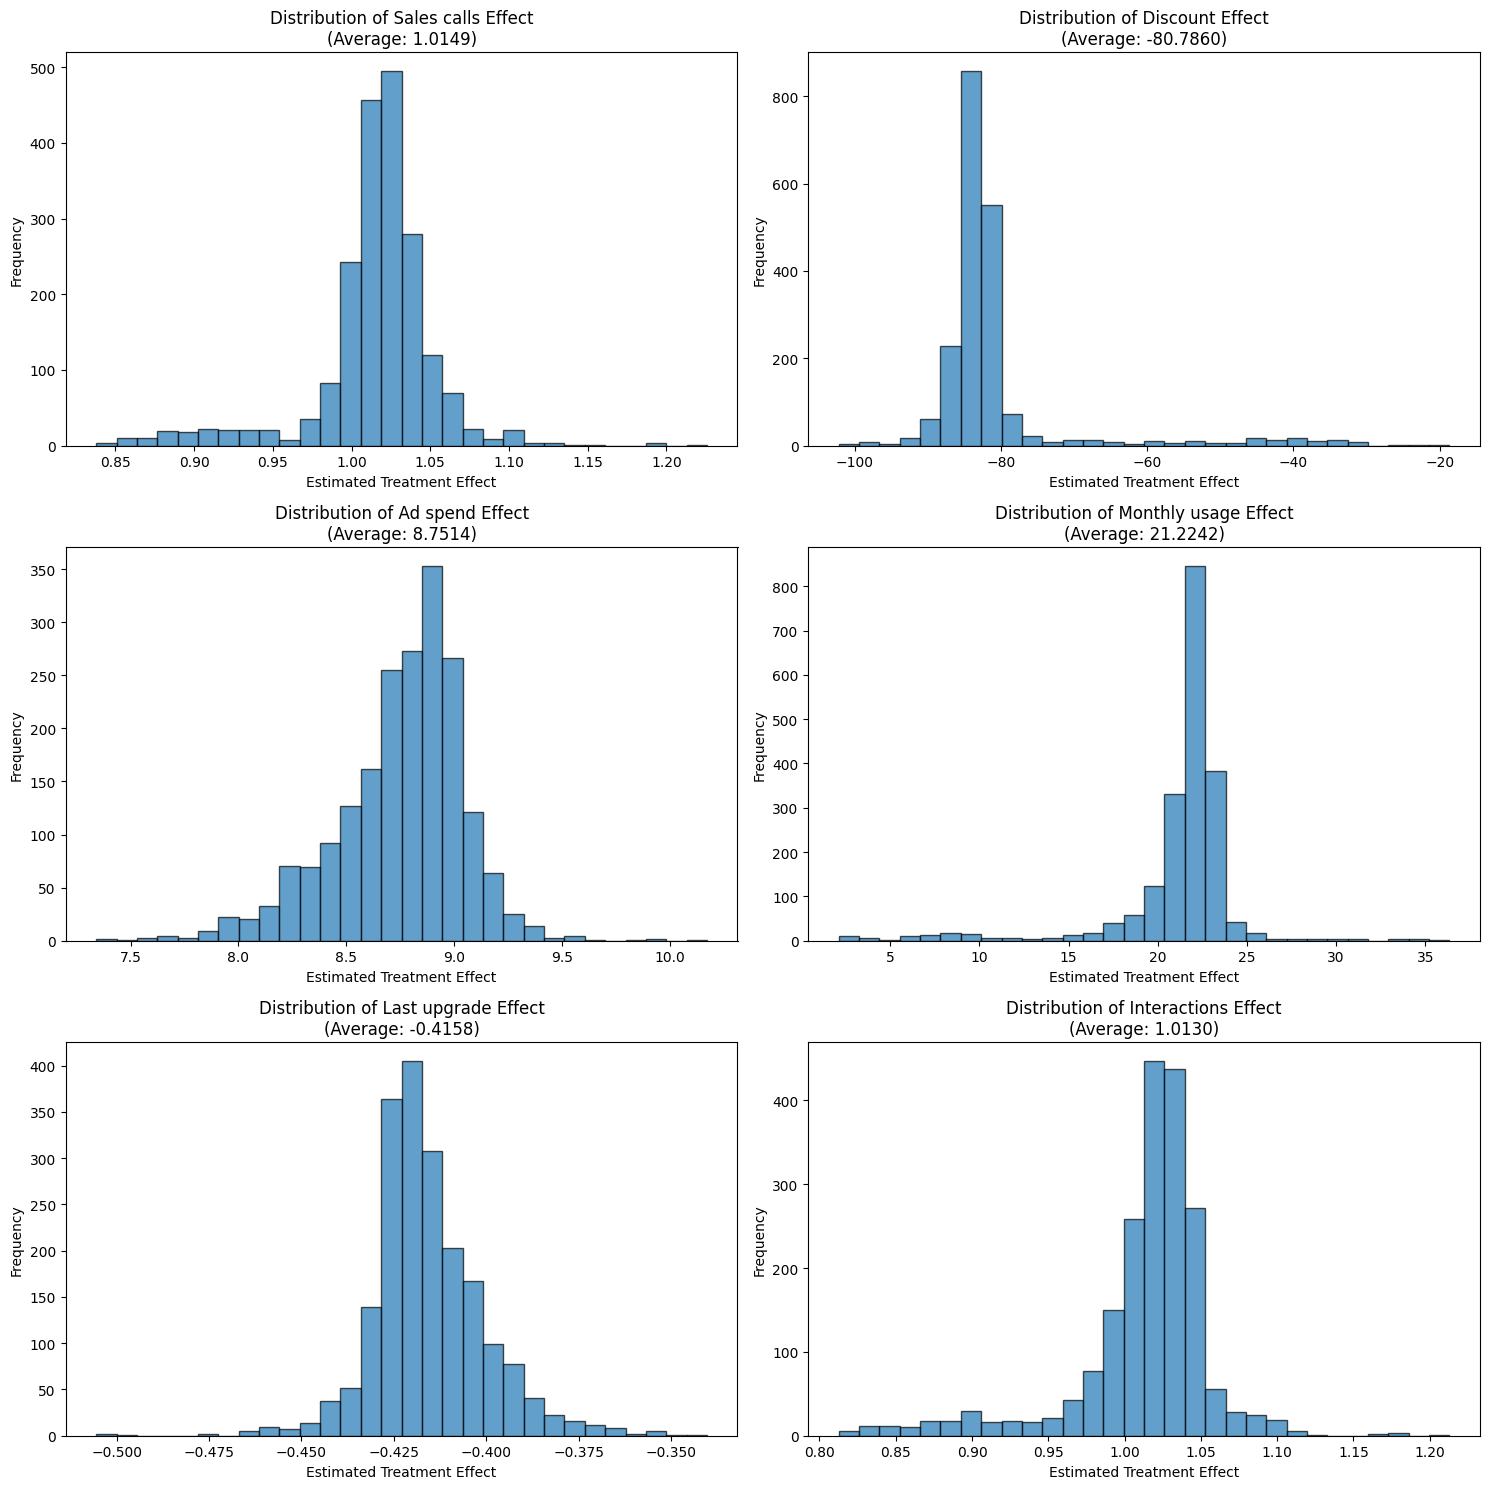

In [33]:
import math
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor

# Step 1: Generate and split the dataset
X, y = create_continuous_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define treatments and covariates
treatments = ["Sales calls", "Discount", "Ad spend", "Monthly usage", "Last upgrade", "Interactions"]

covariates = [col for col in X.columns if col not in treatments]

# Step 3: Initialize results container
results = []

# Step 4: Iterate over treatments
for treatment in treatments:
    # Define treatment and covariates for the current iteration
    T_train = X_train[treatment]
    T_test = X_test[treatment]
    X_train_covariates = X_train[covariates]
    X_test_covariates = X_test[covariates]

    # Initialize and fit the causal forest model
    causal_forest = CausalForestDML(
        model_y=RandomForestRegressor(),
        model_t=RandomForestRegressor(),
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=10,
        random_state=42,
    )
    causal_forest.fit(Y=y_train, T=T_train, X=X_train_covariates)

    # Estimate treatment effects
    treatment_effects = causal_forest.effect(X_test_covariates)

    # Add the estimated effects as a new column in the test set
    X_test[f"estimated_{treatment}_effect"] = treatment_effects

    # Store average treatment effect (ATE)
    results.append({
        "Treatment": treatment,
        "Average Treatment Effect": treatment_effects.mean()
    })

# Step 5: Summarize results in a DataFrame
results_df = pd.DataFrame(results)

# Step 6: Print ATEs and plot distributions
def plot_treatment_effects_with_averages(X_test, treatments):
    n_treatments = len(treatments)
    n_cols = 2  # Two plots per row
    n_rows = math.ceil(n_treatments / n_cols)  # Calculate the number of rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    print("Average Estimated Treatment Effects:\n")
    for idx, treatment in enumerate(treatments):
        ax = axes[idx]

        # Calculate the average treatment effect
        effect_col_name = f"estimated_{treatment}_effect"
        average_effect = X_test[effect_col_name].mean()

        # Print the average
        print(f"{treatment}: {average_effect:.4f}")

        # Plot the histogram
        ax.hist(X_test[effect_col_name], bins=30, alpha=0.7, edgecolor='k')
        ax.set_title(f"Distribution of {treatment} Effect\n(Average: {average_effect:.4f})")
        ax.set_xlabel("Estimated Treatment Effect")
        ax.set_ylabel("Frequency")

    # Turn off unused subplots
    for idx in range(len(treatments), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to print and plot results
print("Summary of Average Treatment Effects:")
plot_treatment_effects_with_averages(X_test, treatments)

# **Double ML Method**

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

def double_ml(X, y, random_state=42):
    """Applies Double Machine Learning for each treatment variable."""
    results = []

    for treatment in X.columns:
        # Define covariates (all variables except the treatment)
        covariates = X.drop(treatment, axis=1)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

        # Residualize outcome (Customer Satisfaction)
        outcome_model = GradientBoostingRegressor(random_state=random_state)
        outcome_model.fit(X_train[covariates.columns], y_train)
        y_residual = y_test - outcome_model.predict(X_test[covariates.columns])

        # Residualize treatment
        treatment_model = GradientBoostingRegressor(random_state=random_state)
        treatment_model.fit(X_train[covariates.columns], X_train[treatment])
        treatment_residual = X_test[treatment] - treatment_model.predict(X_test[covariates.columns])

        # Estimate causal effect using Linear Regression
        regression = LinearRegression()
        regression.fit(treatment_residual.values.reshape(-1, 1), y_residual)
        causal_effect = regression.coef_[0]

        results.append({
            "Treatment": treatment,
            "Causal Effect": causal_effect
        })

    return pd.DataFrame(results)

# Apply Double ML
results = double_ml(X, y)
print(results)


       Treatment  Causal Effect
0    Sales calls       0.497139
1   Interactions       0.335429
2        Economy       1.982445
3   Last upgrade      -0.618960
4       Discount     -32.378345
5  Monthly usage       1.150518
6       Ad spend       1.318384
7  Bugs reported      -0.273272
